In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time as t
from scipy.signal import resample
from scipy.ndimage import zoom

def normalize_array(arr, a, b):
    arr_min, arr_max = arr.min(), arr.max()
    return a + (b - a) * (arr - arr_min) / (arr_max - arr_min)


# 定义温度分布
def temperature_distribution(x, y, length=24, width=3, T_left=1900, T_middle=300, T_right=1900):
    """
    计算给定 x, y 位置处的温度，根据左、中、右三部分的温度及线性插值。
    """
    T = np.zeros_like(x)
    
    # 左侧1/3区域温度为T_left
    T[x < length/3] = T_left
    
    # 中间1/5区域温度为T_middle
    T[(x >= 11.3) & (x <= 12.7)] = T_middle
    
    # 右侧1/3区域温度为T_right
    T[x > 16] = T_right
    
    # 左侧线性插值区域
    mask_left_interp = (x >= length/3) & (x < 11.3)
    T[mask_left_interp] = np.interp(x[mask_left_interp], [8, 11.3], [T_left, T_middle])
    
    # 右侧线性插值区域
    mask_right_interp = (x > 12.7) & (x <= 16)
    T[mask_right_interp] = np.interp(x[mask_right_interp], [12.7, 16], [T_middle, T_right])
    
    return T

# 定义吸收系数分布
def absorption_coefficient(T, T_ref=300, alpha_ref=1):
    """
    根据温度分布计算吸收系数分布，假设吸收系数与温度成正比。
    """
    return alpha_ref * (T / T_ref)

def initial_laser(total_energy, fwhm_time, initial_diameter):
    # 计算时间上的标准差
    sigma_time = fwhm_time / (2 * np.sqrt(2 * np.log(2)))  # FWHM 转换为标准差
    # 设置时间轴范围为中心点左右各 3σ
    time_range = 6 * sigma_time
    time = np.linspace(-time_range/2, time_range/2, 5000)  # 时间轴覆盖 6σ 范围

    # 直径轴（以厘米为单位）
    diameter = np.linspace(-initial_diameter/2, initial_diameter/2, 300)  # -0.35到0.35 cm
    diameter_sigma = initial_diameter / (2 * np.sqrt(2 * np.log(2)))  # FWHM 转换为标准差

    # 计算时间上的高斯分布
    intensity_time = np.exp(-((time)**2) / (2 * sigma_time**2))

    # 计算空间上的高斯分布（直径）
    intensity_diameter = np.exp(-diameter**2 / (2 * diameter_sigma**2))

    # 归一化：确保总能量在时间和空间上的分布独立
    normalized_intensity_time = intensity_time / np.sum(intensity_time)
    normalized_intensity_diameter = intensity_diameter / np.sum(intensity_diameter)

    # 构建二维强度分布，保持时间和空间分布独立
    intensity = np.outer(normalized_intensity_time, normalized_intensity_diameter)

    # 归一化到总能量
    intensity *= total_energy / (time[1] - time[0]) / (diameter[1] - diameter[0])

    # 可视化
    plt.figure()
    plt.imshow(intensity, extent=[time.min()*1e9, time.max()*1e9, diameter.min(), diameter.max()], 
               aspect='auto', cmap='hot', origin='lower')
    plt.colorbar(label="Intensity (J/cm²)")
    plt.xlabel('Time (ns)')
    plt.ylabel('Diameter (cm)')
    plt.title('Initial Laser Pulse Intensity Distribution')
    plt.show()

    time = np.linspace(0, time_range, 5000) # 修改返回值方便计算
    return time, diameter, intensity

# 泊松方程求解
def solve_poisson(phi, rho,cell_size, num_iterations=100):
    for _ in range(num_iterations):
        phi_new = np.copy(phi)
        phi_new[1:-1, 1:-1] = (
            phi[2:, 1:-1] + phi[:-2, 1:-1] +
            phi[1:-1, 2:] + phi[1:-1, :-2] -
            rho[1:-1, 1:-1] * cell_size**2
        ) / 4.0
        phi = phi_new
    return phi

# 计算电场
def compute_electric_field(phi, cell_size):
    ex = (phi[2:, 1:-1] - phi[:-2, 1:-1]) / (2 * cell_size)
    ey = (phi[1:-1, 2:] - phi[1:-1, :-2]) / (2 * cell_size)
    return ex, ey

# 初始化粒子位置和速度
def initialize_positions_velocities(num_particles,x_min,y_min,cell_size, mass, temperature, k_B):
    all_position = []
    all_velocities = []
    for i in range(len(num_particles)):
        positions_0 = np.random.uniform(x_min[i], x_min[i] + cell_size, num_particles[i])
        positions_1 = np.random.uniform(y_min[i], y_min[i] + cell_size, num_particles[i])
        positions = np.vstack((positions_0,positions_1)).T
        
        velocities = np.random.normal(0, np.sqrt(k_B * 9000 / mass) * 100, (num_particles[i], 2))  # m/s 转换为 cm/s # 8000k
        all_position.append(positions)
        all_velocities.append(velocities)
    return all_position, all_velocities


# 计算电荷密度
def compute_charge_density(positions, charge, x_shape, y_shape, domain_size):
    
    x_edges = np.linspace(0, 24, x_shape + 1)
    y_edges = np.linspace(-1.4, 1.4, y_shape + 1)
    bin_edges = [x_edges,y_edges]
    hist, _, _ = np.histogram2d(positions[:, 0] , positions[:, 1], bins=bin_edges)
    rho = hist * charge
    return rho

# 计算电场加速度
def compute_acceleration(positions, electric_field, grid_size, cell_size, charge, mass):
    
    grid_positions_x = np.floor(positions[:,0] / cell_size).astype(int)
    grid_positions_x = np.clip(grid_positions_x, 0, grid_size - 1)

    grid_positions_y = np.floor((positions[:,1] + 1.4)/ cell_size).astype(int)
    grid_positions_y = np.clip(grid_positions_y, 0, grid_size - 1)

    # 提取电场分量
    ex = electric_field[grid_positions_x, grid_positions_y, 0]
    ey = electric_field[grid_positions_x, grid_positions_y, 1]
    
    # 计算加速度
    accelerations = (charge / mass) * np.vstack((ex, ey)).T
    
    return accelerations

# 更新粒子位置和速度（使用Verlet方法）
def verlet_update(positions, velocities, accelerations, new_accelerations, dt, x_min,x_max,y_min,y_max):
    ## 边界条件
    new_positions = positions + velocities * dt + 0.5 * accelerations * dt**2
    new_velocities = velocities + 0.5 * (accelerations + new_accelerations) * dt

    new_velocities = new_velocities[new_positions[:,0] < x_max]
    new_positions = new_positions[new_positions[:,0] < x_max]
    new_velocities = new_velocities[new_positions[:,0] > x_min]
    new_positions = new_positions[new_positions[:,0] > x_min]

    new_velocities = new_velocities[new_positions[:,1] < y_max]
    new_positions = new_positions[new_positions[:,1] < y_max]
    new_velocities = new_velocities[new_positions[:,1] > y_min]
    new_positions = new_positions[new_positions[:,1] > y_min]

    return new_positions, new_velocities



In [2]:
# 定义参数
total_energy = 50e-3  # 50 mJ
fwhm_time = 7e-9  # 7 ns
initial_diameter = 0.7  # 初始直径 0.7 cm
c = 3e8  # 光速，单位为米/秒
n = 1.0003  # 空气的折射率
c_air = c / n  # 在空气中的光速
time_step = 3e-11  # 1 ns
step_size = c_air * time_step  # 每步光程
enter_flag = 1 # 判断激光完全传入
ion_flag = 0 # 判断电离
w0 = initial_diameter/2 
dWave=1.064
Rel_L = np.pi * w0**2 / dWave

mass_ion = 14*1.6726219e-27   # kg (N质量)
charge_ion = 1.60217662e-19  # C （+1价）
k_B = 1.38064852e-23  # J/K
epsilon_0 = 8.854187817e-12  # F/m (真空介电常数)

grid_size = 2400
domain_size = 24
cell_size = domain_size/grid_size
# 保存图像的路径
output_dir = 'laser_images/'
os.makedirs(output_dir, exist_ok=True)


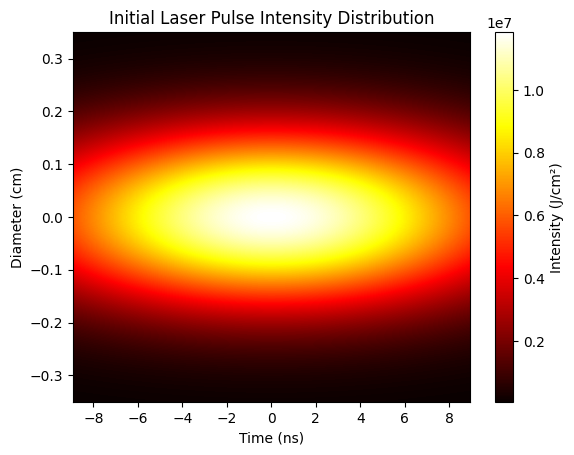

In [3]:
# 初始化盒子
x = np.linspace(0, domain_size, grid_size)  # cm
y = np.linspace(-2*initial_diameter, 2*initial_diameter, int(4*initial_diameter / cell_size))  # cm
x_shape,y_shape = x.shape[0], y.shape[0]
intensity_box = np.zeros((x_shape, y_shape))
absorb_box = np.zeros((x_shape, y_shape))
electric_field = np.zeros((x_shape, y_shape,2))
phi_field = np.zeros((x_shape, y_shape))
ion_box = np.zeros((x_shape, y_shape))
ion_positions = np.zeros((2,2))
ion_velocities = []

# 初始激光强度分布
time, diameter, initial_intensity = initial_laser(total_energy, fwhm_time, initial_diameter)

# 计算初始束腰 和对应box 内索引
w = np.sqrt(w0**2+(x - x.mean())**2*dWave**2/np.pi**2/w0**2)
normal_w = w * w0/max(w)
normal_w_index1 = [np.where(y >= normal_ws)[0][0] for normal_ws in normal_w]
normal_w_index2 = [np.where(y <= -normal_ws)[0][-1] for normal_ws in normal_w]

# 计算温度和吸收系数分布
X, Y = np.meshgrid(x, y)

T_map = temperature_distribution(X, Y)
alpha_map = absorption_coefficient(T_map)
alpha_map = np.exp(-alpha_map*cell_size/10)
alpha_map[:,int(grid_size/2):grid_size] = alpha_map[:,::-1][:,int(grid_size/2):grid_size]

# # 二维的高斯光束半径变化图
# fig =  plt.figure()
# ax1 = fig.add_subplot()
# ax1.plot(x,normal_w,linewidth=1)
# ax1.plot(x,-normal_w,linewidth=0.2)
# ax1.set_title("waist value changed by propagation")

# # 可视化温度分布
# plt.figure(figsize=(10, 3))
# plt.contourf(X, Y, T_map, levels=50, cmap='plasma')
# plt.colorbar(label='Temperature (K)')
# plt.title('Temperature Distribution')
# plt.xlabel('x (cm)')
# plt.ylabel('y (cm)')
# plt.show()

# # 可视化吸收系数分布
# plt.figure(figsize=(10, 3))
# plt.contourf(X, Y, alpha_map, levels=50, cmap='viridis')
# plt.colorbar(label='Absorption Coefficient')
# plt.title('Absorption Coefficient Distribution')
# plt.xlabel('x (cm)')
# plt.ylabel('y (cm)')
# plt.show()
for step in range(0,39):
    
    if step == 80:
        time_step = 1e-8
        enter_flag = 0


    # 更新格子中激光位置
    if step > 0 and step < 80:
        move_step = start_box - end_box
        intensity_box[move_step:,:] = intensity_box[:-move_step,:]
        intensity_box[:move_step - 1,:] = 0

    # 计算要进入的激光
    if enter_flag == 1:
        
        if step == 0:
            start_index = np.where(time >= (time_step * step))[0][0] #
        else: 
            start_index = end_index 
        end_index = np.where(time >= (time_step * (step+1)))[0] # 
        if end_index.size == 0:
            enter_flag = 0
            end_index = time.shape[0]
        else:
            end_index = end_index[0]  
             
    # resample 激光
        in_laser = initial_intensity[start_index:end_index,:][::-1,:]
        start_box = np.where(x >= (c_air * time_step * 100))[0][0] 
        end_box = max([start_box - np.where(x >= (c_air * (time[end_index]-time[start_index]) * 100))[0][0] , 0])
        start_diem = np.where(y >= diameter[-1])[0][0]
        end_diem = np.where(y <= diameter[0])[0][-1]

        zoom_factors = ((start_box-end_box)/len(in_laser[:,0]),(start_diem-end_diem)/len(in_laser[0,:]))
        resampled_in_laser = zoom(in_laser,zoom_factors,order=1)
        
        intensity_box[end_box:start_box,end_diem:start_diem] = normalize_array(resampled_in_laser,in_laser.min(),in_laser.max())
        
        # plt.figure(figsize=(10, 6))
        # plt.imshow(in_laser, aspect='auto', cmap='hot')
        # plt.colorbar(label='Intensity (J/cm²)')


    # 更新高斯线形和吸收
    for xs in range(len(x)):
        if step < 80:
            origin_boxs = intensity_box[xs,:][intensity_box[xs,:]>0]
            
            if len(origin_boxs) != 0:
                intensity_box[xs,:] = 0
                intensity_box[xs,normal_w_index2[xs]:normal_w_index1[xs]] = resample(origin_boxs, normal_w_index1[xs]-normal_w_index2[xs]) * len(origin_boxs) / (normal_w_index1[xs]-normal_w_index2[xs])
        # 存储吸收光场    
            if ion_flag == 0:
                absorb_box += intensity_box * (1-alpha_map.T)
                absorb_box -= absorb_box[absorb_box>0].min()
            else:
                ion_a = (1-alpha_map.T) 
                ion_a[:,ionlization_position[0].max():-1] = ion_a[:,ionlization_position[0].max():-1]/2 # 考虑吸收衰减(经过所有产生的等离子体)
                absorb_box += ion_a
                absorb_box -= absorb_box[absorb_box>0].min()

            
    # 判断电离条件    
    ionlization_position = np.where(absorb_box >= max(0.1 * absorb_box.max(),1e7))

    if (len(ionlization_position[0]) > 1 and step > 40):
        # 开始电离
        # 更新初始离子
        print('start_ionlization')

        if len(ion_positions[:,0]) < 10000000: # ion_
            particle_mun = normalize_array(absorb_box[ionlization_position[0],ionlization_position[1]],10,1e12 * time_step).astype(int)
            ion_position,ion_velocitiy = initialize_positions_velocities(particle_mun,x[ionlization_position[0]],y[ionlization_position[1]],cell_size,mass_ion,\
                                            T_map.T[ionlization_position[0],ionlization_position[1]],k_B)
            if ion_flag==0:
                ion_positions = np.vstack(ion_position)
                ion_velocities = np.vstack(ion_velocitiy)
            else:
                ion_positions = np.vstack((ion_positions,np.vstack(ion_position)))
                ion_velocities = np.vstack((ion_velocities,np.vstack(ion_velocitiy)))                
        
        ion_flag = 1
        
        # 计算电势
        rho_i = compute_charge_density(ion_positions, charge_ion, x_shape,y_shape, domain_size)
        phi_field = solve_poisson(phi_field, rho_i,cell_size)

        # 计算初始电场
        ex, ey = compute_electric_field(phi_field, cell_size)
        ex = np.pad(ex, ((1, 1), (1, 1)), mode='constant', constant_values=0)
        ey = np.pad(ey, ((1, 1), (1, 1)), mode='constant', constant_values=0)
        electric_field[:, :, 0] = ex
        electric_field[:, :, 1] = ey

        # 计算加速度  
        ion_acceleration = compute_acceleration(ion_positions, electric_field, grid_size, cell_size, charge_ion, mass_ion)

        # verlet法更新位置  ·
        ion_positions, ion_velocities = verlet_update(ion_positions, ion_velocities, ion_acceleration, ion_acceleration, time_step, x.min(),x.max(),y.min(),y.max())
    # # 绘制当前时间步的强度分布

    # fig1, ax1 = plt.subplots(figsize=(10, 6))
    # im1 = ax1.imshow(intensity_box.T, extent=[0, 24, y.min(), y.max()], aspect='auto', cmap='hot')
    # ax1.set_title(f'Step {step+1}: Time = {step * time_step * 1e9:.1f} ns')
    # fig1.colorbar(im1, ax=ax1, label='Intensity (J/cm²)')
    # plt.savefig(f'Intensity_Step_{step+1}.png')
    # plt.close(fig1)

    # fig2, ax2 = plt.subplots(figsize=(10, 6))
    # im2 = ax2.imshow(absorb_box.T, extent=[0, 24, y.min(), y.max()], aspect='auto', cmap='hot')
    # ax2.set_title(f'Step {step+1}: Time = {step * time_step * 1e9:.1f} ns.png')
    # fig2.colorbar(im2, ax=ax2, label='Intensity (J/cm²)')
    # plt.savefig(f'Absorb_Step_{step+1}.png')
    # plt.close(fig2)
    # print(f'step = {step}')
    
    if ion_flag == 1:
        hist_i, _, _ = np.histogram2d(ion_positions[:, 0], ion_positions[:, 1] , bins=[np.linspace(0, 24, x_shape + 1),np.linspace(-initial_diameter/2, initial_diameter/2, y_shape + 1)])
        efield_magnitude = np.sqrt(electric_field[:, :, 0]**2 + electric_field[:, :, 1]**2)
        # 绘制离子位置图
        fig3, ax3 = plt.subplots(figsize=(10, 6))
        im3 = ax3.imshow(hist_i.T, extent=[0, 24, y.min(), y.max()], origin='lower', cmap='plasma')
        if step < 80:
            ax3.set_title(f'Ion Positions (Step {step * time_step * 1e9:.1f} ))')
        else:
            ax3.set_title(f'Ion Positions (Step {(step-80) * time_step * 1e9 + 8:.1f} ))')
        ax3.set_ylim(0, 500)    
        fig3.colorbar(im3, ax=ax3, label='Ion Density')
        plt.savefig(f'ion_positions_step_{step}.png')
        plt.close(fig3)

        # 绘制电场图
        fig4, ax4 = plt.subplots(figsize=(10, 6))
        im4 = ax4.imshow(efield_magnitude.T,extent=[0, 24, y.min(), y.max()], origin='lower', cmap='plasma')
        ax4.set_title(f'Electric Field Magnitude (Step {step * time_step * 1e9:.1f} )')
        fig4.colorbar(im4, ax=ax4, label='Electric Field (V/m)')
        plt.savefig(f'electric_field_step_{step}.png')
        plt.close(fig4)

    #判据 瑞丽长度之内，进行激光能量计数

In [4]:
# 初始化盒子
x = np.linspace(0, domain_size, grid_size)  # cm
y = np.linspace(-2*initial_diameter, 2*initial_diameter, int(4*initial_diameter / cell_size))  # cm
x_shape,y_shape = x.shape[0], y.shape[0]
electric_field = np.zeros((x_shape, y_shape,2))
phi_field = np.zeros((x_shape, y_shape))
ion_box = np.zeros((x_shape, y_shape))
ion_positions = np.zeros((2,2))
ion_velocities = []

In [5]:


for step in range(0,300):
    
    if step == 80:
        time_step = 1e-8
        enter_flag = 0


    # 更新格子中激光位置
    if step > 0 and step < 80:
        move_step = start_box - end_box
        intensity_box[move_step:,:] = intensity_box[:-move_step,:]
        intensity_box[:move_step - 1,:] = 0

    # 计算要进入的激光
    if enter_flag == 1:
        
        if step == 0:
            start_index = np.where(time >= (time_step * step))[0][0] #
        else: 
            start_index = end_index 
        end_index = np.where(time >= (time_step * (step+1)))[0] # 
        if end_index.size == 0:
            enter_flag = 0
            end_index = time.shape[0]
        else:
            end_index = end_index[0]  
             
    # resample 激光
        in_laser = initial_intensity[start_index:end_index,:][::-1,:]
        start_box = np.where(x >= (c_air * time_step * 100))[0][0] 
        end_box = max([start_box - np.where(x >= (c_air * (time[end_index]-time[start_index]) * 100))[0][0] , 0])
        start_diem = np.where(y >= diameter[-1])[0][0]
        end_diem = np.where(y <= diameter[0])[0][-1]

        zoom_factors = ((start_box-end_box)/len(in_laser[:,0]),(start_diem-end_diem)/len(in_laser[0,:]))
        resampled_in_laser = zoom(in_laser,zoom_factors,order=1)
        
        intensity_box[end_box:start_box,end_diem:start_diem] = normalize_array(resampled_in_laser,in_laser.min(),in_laser.max())
        
        # plt.figure(figsize=(10, 6))
        # plt.imshow(in_laser, aspect='auto', cmap='hot')
        # plt.colorbar(label='Intensity (J/cm²)')


    # 更新高斯线形和吸收
    for xs in range(len(x)):
        if step < 80:
            origin_boxs = intensity_box[xs,:][intensity_box[xs,:]>0]
            
            if len(origin_boxs) != 0:
                intensity_box[xs,:] = 0
                intensity_box[xs,normal_w_index2[xs]:normal_w_index1[xs]] = resample(origin_boxs, normal_w_index1[xs]-normal_w_index2[xs]) * len(origin_boxs) / (normal_w_index1[xs]-normal_w_index2[xs])
        # 存储吸收光场    
            if ion_flag == 0:
                absorb_box += intensity_box * (1-alpha_map.T)
                absorb_box -= absorb_box[absorb_box>0].min()
            else:
                ion_a = (1-alpha_map.T) 
                ion_a[:,ionlization_position[0].max():-1] = ion_a[:,ionlization_position[0].max():-1]/2 # 考虑吸收衰减(经过所有产生的等离子体)
                absorb_box += ion_a
                absorb_box -= absorb_box[absorb_box>0].min()

            
    # 判断电离条件    
    ionlization_position = np.where(absorb_box >= max(0.4 * absorb_box.max(),1e7))

    if (len(ionlization_position[0]) > 1 and step > 40):
        # 开始电离
        # 更新初始离子
        print('start_ionlization')

        if len(ion_positions[:,0]) < 10000000: # ion_
            particle_mun = normalize_array(absorb_box[ionlization_position[0],ionlization_position[1]],100,1e12 * time_step).astype(int)
            ion_position,ion_velocitiy = initialize_positions_velocities(particle_mun,x[ionlization_position[0]],y[ionlization_position[1]],cell_size,mass_ion,\
                                            T_map.T[ionlization_position[0],ionlization_position[1]],k_B)
            if ion_flag==0:
                ion_positions = np.vstack(ion_position)
                ion_velocities = np.vstack(ion_velocitiy)
            else:
                ion_positions = np.vstack((ion_positions,np.vstack(ion_position)))
                ion_velocities = np.vstack((ion_velocities,np.vstack(ion_velocitiy)))                
        
        ion_flag = 1
        
        # 计算电势
        rho_i = compute_charge_density(ion_positions, charge_ion, x_shape,y_shape, domain_size)
        phi_field = solve_poisson(phi_field, rho_i,cell_size)

        # 计算初始电场
        ex, ey = compute_electric_field(phi_field, cell_size)
        ex = np.pad(ex, ((1, 1), (1, 1)), mode='constant', constant_values=0)
        ey = np.pad(ey, ((1, 1), (1, 1)), mode='constant', constant_values=0)
        electric_field[:, :, 0] = ex
        electric_field[:, :, 1] = ey

        # 计算加速度  
        ion_acceleration = compute_acceleration(ion_positions, electric_field, grid_size, cell_size, charge_ion, mass_ion)

        # verlet法更新位置  ·
        ion_positions, ion_velocities = verlet_update(ion_positions, ion_velocities, ion_acceleration, ion_acceleration, time_step, x.min(),x.max(),y.min(),y.max())
    # # 绘制当前时间步的强度分布

    fig1, ax1 = plt.subplots(figsize=(10, 6))
    im1 = ax1.imshow(intensity_box.T, extent=[0, 24, y.min(), y.max()], aspect='auto', cmap='hot')
    ax1.set_title(f'Step {step+1}: Time = {step * time_step * 1e9:.1f} ns')
    fig1.colorbar(im1, ax=ax1, label='Intensity (J/cm²)')
    plt.savefig(f'Intensity_Step_{step+1}.png')
    plt.close(fig1)

    fig2, ax2 = plt.subplots(figsize=(10, 6))
    im2 = ax2.imshow(absorb_box.T, extent=[0, 24, y.min(), y.max()], aspect='auto', cmap='hot')
    ax2.set_title(f'Step {step+1}: Time = {step * time_step * 1e9:.1f} ns.png')
    fig2.colorbar(im2, ax=ax2, label='Intensity (J/cm²)')
    plt.savefig(f'Absorb_Step_{step+1}.png')
    plt.close(fig2)
    print(f'step = {step}')
    
    if ion_flag == 1:
        hist_i, _, _ = np.histogram2d(ion_positions[:, 0], ion_positions[:, 1] , bins=[np.linspace(0, 24, x_shape + 1),np.linspace(-initial_diameter/2, initial_diameter/2, y_shape + 1)])
        efield_magnitude = np.sqrt(electric_field[:, :, 0]**2 + electric_field[:, :, 1]**2)
        # 绘制离子位置图
        fig3, ax3 = plt.subplots(figsize=(10, 6))
        im3 = ax3.imshow(hist_i.T, extent=[0, 24, y.min(), y.max()], origin='lower', cmap='plasma')
        ax3.set_title(f'Ion Positions (Step {step})')
        fig3.colorbar(im3, ax=ax3, label='Ion Density')
        plt.savefig(f'ion_positions_step_{step}.png')
        plt.close(fig3)

        # 绘制电场图
        fig4, ax4 = plt.subplots(figsize=(10, 6))
        im4 = ax4.imshow(efield_magnitude.T,extent=[0, 24, y.min(), y.max()], origin='lower', cmap='plasma')
        ax4.set_title(f'Electric Field Magnitude (Step {step})')
        fig4.colorbar(im4, ax=ax4, label='Electric Field (V/m)')
        plt.savefig(f'electric_field_step_{step}.png')
        plt.close(fig4)

    #判据 瑞丽长度之内，进行激光能量计数

step = 0
step = 1
step = 2
step = 3
step = 4
step = 5
step = 6
step = 7
step = 8
step = 9
step = 10
step = 11
step = 12
step = 13
step = 14
step = 15
step = 16
step = 17
step = 18
step = 19
step = 20
step = 21
step = 22
step = 23
step = 24
step = 25
step = 26
step = 27
step = 28
step = 29
step = 30
step = 31
step = 32
step = 33
step = 34
step = 35
step = 36
step = 37
step = 38
step = 39
step = 40
start_ionlization
step = 41
start_ionlization
step = 42
start_ionlization
step = 43
start_ionlization
step = 44
start_ionlization
step = 45
start_ionlization
step = 46
start_ionlization
step = 47
start_ionlization
step = 48
start_ionlization
step = 49
start_ionlization
step = 50
start_ionlization
step = 51
start_ionlization
step = 52
start_ionlization
step = 53
start_ionlization
step = 54
start_ionlization
step = 55
start_ionlization
step = 56
start_ionlization
step = 57
start_ionlization
step = 58
start_ionlization
step = 59
start_ionlization
step = 60
start_ionlization
step = 61
start_ionliz